In [47]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
# Load data and select first column


In [48]:
EOS_FAM = pd.read_csv('EOS.csv', delimiter=';')

In [49]:
EOS_FAM.replace([np.inf, -np.inf], np.nan)
CEOS=EOS_FAM.dropna(subset=['DIA.', 'AMAX', 'PERIOD'])
#new_EOS_FAM = EOS_FAM.drop('DIA',axis ='columns')
freq3=(24)/(np.array(CEOS['PERIOD']))

In [50]:
y=CEOS['DIA.'].values
#DIA.shape
x= np.arange(len(y))
size = len(y)

In [51]:
plt.hist(y)
plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6700 64-bit)
entering extended mode

(C:/Users/RcrdPhysics/.matplotlib/tex.cache/3bbc0f8d536770a62891b7cc8788c317.te
x
LaTeX2e <2018-04-01> patch level 5
Babel <3.20> and hyphenation patterns for 75 language(s) loaded.

("C:\Users\RcrdPhysics\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\article
.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class

("C:\Users\RcrdPhysics\AppData\Local\Programs\MiKTeX 2.9\tex\latex\base\size10.
clo"))
======================================================================

Unfortunately, the package type1cm could not be installed.Please check the log file:
C:/Users/RcrdPhysics/AppData/Local/MiKTeX/2.9/miktex/log/latex.log
======================================================================


! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.4 
     
No pages of output.
Transcript written on 3bbc0f8d536770a62891b7cc8788c317.log.




<Figure size 432x288 with 1 Axes>

In [28]:
y_df = pd.DataFrame(y, columns=['Data'])
y_df.describe()

,Data
count,414.000000
mean,22.816185
std,75.290473
min,1.330000
25%,5.278250
50%,7.408000
75%,12.088750
max,975.095000


In [29]:
sc=StandardScaler() 
yy = y.reshape (-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy

In [30]:
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'maxwell',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
   Distribution    chi_square  p_value
4       lognorm    276.217141      0.0
0          beta    452.232791      0.0
6      pearson3   1650.629421      0.0
2         expon   1650.884483      0.0
9   weibull_min   2004.689723      0.0
1       maxwell   7319.352022      0.0
5          norm   7919.172635      0.0
7        triang   9072.377981      0.0
8       uniform   9559.871680      0.0
10  weibull_max  10081.868284      0.0
3         gamma  27108.491107      0.0


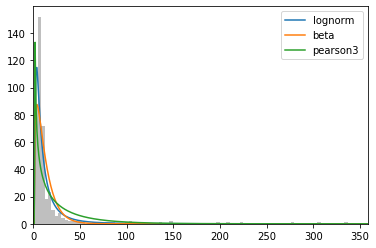


Distribution parameters:
------------------------

Distribution: lognorm
Parameters: (1.1039498611078495, 1.2534139939069093, 7.454846446106183)

Distribution: beta
Parameters: (1.2954708889403244, 789468799.8386372, 1.3170684089178133, 6888230856.462683)

Distribution: pearson3
Parameters: (2.6954752259267067, 23.80906130999599, 30.295876431590877)


In [31]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )

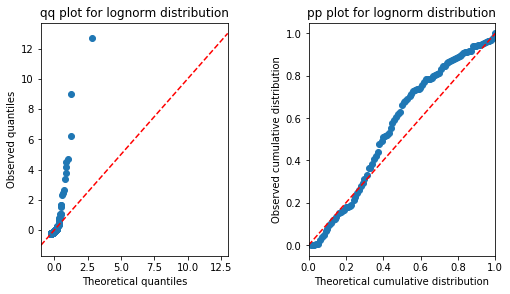

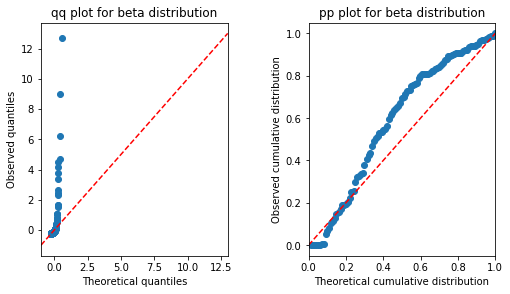

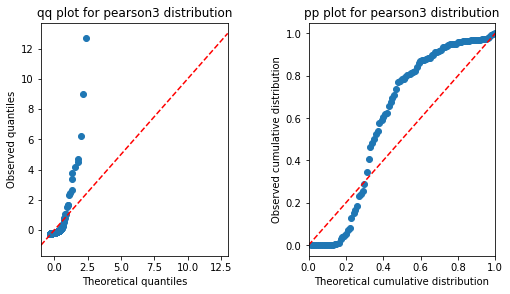

In [32]:
## qq and pp plots
    
data = y_std.copy()
data.sort()

# Loop through selected distributions (as previously selected)

for distribution in dist_names:
    # Set up distribution
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Get random numbers from distribution
    norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
    norm.sort()
    
    # Create figure
    fig = plt.figure(figsize=(8,5)) 
    
    # qq plot
    ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
    ax1.plot(norm,data,"o")
    min_value = np.floor(min(min(norm),min(data)))
    max_value = np.ceil(max(max(norm),max(data)))
    ax1.plot([min_value,max_value],[min_value,max_value],'r--')
    ax1.set_xlim(min_value,max_value)
    ax1.set_xlabel('Theoretical quantiles')
    ax1.set_ylabel('Observed quantiles')
    title = 'qq plot for ' + distribution +' distribution'
    ax1.set_title(title)
    
    # pp plot
    ax2 = fig.add_subplot(122)
    
    # Calculate cumulative distributions
    bins = np.percentile(norm,range(0,101))
    data_counts, bins = np.histogram(data,bins)
    norm_counts, bins = np.histogram(norm,bins)
    cum_data = np.cumsum(data_counts)
    cum_norm = np.cumsum(norm_counts)
    cum_data = cum_data / max(cum_data)
    cum_norm = cum_norm / max(cum_norm)
    
    # plot
    ax2.plot(cum_norm,cum_data,"o")
    min_value = np.floor(min(min(cum_norm),min(cum_data)))
    max_value = np.ceil(max(max(cum_norm),max(cum_data)))
    ax2.plot([min_value,max_value],[min_value,max_value],'r--')
    ax2.set_xlim(min_value,max_value)
    ax2.set_xlabel('Theoretical cumulative distribution')
    ax2.set_ylabel('Observed cumulative distribution')
    title = 'pp plot for ' + distribution +' distribution'
    ax2.set_title(title)
    
    # Display plot    
    plt.tight_layout(pad=4)
    plt.show()